<a href="https://colab.research.google.com/github/MominAhmedShaikh/Artificial-neural-netwrok-ANN-/blob/main/ANN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies and importing libraries

In [1]:
!pip install -U keras-tuner -q
!pip install -U imblearn -q
!pip install -U scikeras -q

In [62]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
from keras import regularizers
from tensorflow import keras
from keras import models
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import keras_tuner

In [3]:
tf.random.set_seed(1) #setting seed to keep the environment equal

# Defining functions

#### Data processing functions

In [119]:
def count_outlier(df_in, col_name):
  '''
  Count number of outliers in a dataset

  Parameters:
  
  df_in = Dataset for which you want to find outlier numbers
  col_name = Column name from given dataset

  '''
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  return len(df_in)-len(df_out)

In [113]:
def univar_cat_analysis(*args,i,t,labels=None):
    '''
    Function for univariate categorical analysis

    Parameters:

    i = column name
    t = title you want to set
    *args = Values on y-axis
    labels = labels you want to add (default = None)
    '''
    
    fig = px.bar(hr_ds,
             x=[hr_ds[i].value_counts()[0],hr_ds[i].value_counts()[1]],
             y=[i for i in args],
             width=900,
             height=300,
             title=t,
             labels=labels)
    return fig.show()

#### Model building functions

In [115]:
def build_model(hp):
    '''
    Function copied from keras tuner documentation. Requires to build model based on keras tuner.
    '''  
    model = keras.Sequential()
    units=hp.Int("input nuerons", min_value=1, max_value=100, step=1)
    activation=hp.Choice("activation", ["relu", "tanh"])
    model.add(Dense(units = units, input_shape=(34,), activation=activation)) # input 

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=1, max_value=100, step=5),  # 1 hidden 
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=['accuracy'] ###
    )
    return model

In [118]:
def model_training(model,x_train,y_train,x_test,y_test):
    
    '''
    Parameters:

    model = After Adding layers inside model, pass that model here!
    x_train = x_train
    y_train = y_train
    x_test = x_test
    y_test = y_test

    Output:
    returns history object later can be fetch for losses and accuracies.

    '''
    model.compile(optimizer='adam'
                  , loss='binary_crossentropy'
                  , metrics=accuracy)
    
    history = model.fit(x_train
                       , y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_data=(x_test, y_test)
                       , verbose=0
                       , callbacks = callback
        )
    
    predictions = model.predict(x_test[0:])
    
    y_pred = []
    for i in predictions:
        if i > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    y = y_test[0:]
    
    
    ConfusionMatrixDisplay(confusion_matrix(y,y_pred)).plot()
    plt.show()
    print(classification_report(y,y_pred,zero_division=0))
    print('ROC_AUC_score:',roc_auc_score(y,y_pred))
    print('Accuracy:',accuracy_score(y,y_pred))
    print('Precision_score:',precision_score(y,y_pred))
    print('Recall_score:',recall_score(y,y_pred))

    
    return history

#### Model evaluation functions

In [10]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model

    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

#### Model loss / Accuracy viz functions

In [131]:
#from traitlets.traitlets import MetaHasDescriptors
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = len(metric_model_1)
    f = len(metric_model_2)
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss',
        'val_binary_accuracy' : 'Validation Binary accuracy',
        'binary_accuracy' : 'Binary accuracy'
    }
    
    metric_label = metrics_dict[metric]

    plt.plot([i for i in range(len(metric_model_1))], metric_model_1, 'b-', label=model_1.name,color = 'blue')
    plt.plot([i for i in range(len(metric_model_2))], metric_model_2, 'b', label=model_2.name,color = 'red')
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [121]:
def plot(model,model_history,title,metric):
    '''
    Plot loss and accuracy of given model

    Parameters:

    model = After Adding layers inside model, pass that model here!
    model_history = Add model history object
    title = title you want to set
    metric = Look for metric (eg . val_loss,val_accuracy,etc)

    '''
    df = pd.DataFrame(model_history.history)
    plt.figure(figsize=(20, 5))
    plt.suptitle(title,fontsize = 20)
    plt.subplot(1, 2, 1)
    
    plt.plot(df[metric],color = 'blue')
    plt.plot(df['val_'+ metric],color = 'red')
    plt.xlabel('# of epochs')
    plt.ylabel('acc metrics')
    plt.legend(['train_accuracy','test_accuracy'])
    
    plt.subplot(1, 2, 2)
    
    plt.plot(df['loss'],color = 'blue')
    plt.plot(df['val_loss'],color = 'red')
    plt.xlabel('# of epochs')
    plt.ylabel('loss metrics')
    plt.legend(['train_loss','test_loss'])
    plt.show()

    
    results = model.evaluate(x_test, y_test)
    return results

# EDA

In [63]:
# Loading dataset
hr_ds = pd.read_csv('/content/HR Interview Analytics.csv')

In [64]:
hr_ds.head()

SLNO  Candidate.Ref DOJ.Extended  Duration.to.accept.offer  Notice.period  \
0     1        2110407          Yes                        14             30   
1     2        2112635           No                        18             30   
2     3        2112838           No                         3             45   
3     4        2115021           No                        26             30   
4     5        2115125          Yes                         1            120   

  Offered.band  Pecent.hike.expected.in.CTC  Percent.hike.offered.in.CTC  \
0           E2                       -20.79                        13.16   
1           E2                        50.00                       320.00   
2           E2                        42.84                        42.84   
3           E2                        42.84                        42.84   
4           E2                        42.59                        42.59   

   Percent.difference.CTC Joining.Bonus Candidate.relocate.actual  Gender  \
0                   42.86            No                        No  Female   
1                  180.00            No                        No    Male   
2                    0.00            No                        No    Male   
3                    0.00            No                        No    Male   
4                    0.00            No                       Yes    Male   

    Candidate.Source  Rex.in.Yrs    LOB Location  Age  Status  
0             Agency           7    ERS    Noida   34       1  
1  Employee Referral           8  INFRA  Chennai   34       1  
2             Agency           4  INFRA    Noida   27       1  
3  Employee Referral           4  INFRA    Noida   34       1  
4  Employee Referral           6  INFRA    Noida   34       1

In [65]:
# Dataset has originally 9011 rows and 18 cols
hr_ds.shape

(9011, 18)

In [66]:
hr_ds.describe()

SLNO  Candidate.Ref  Duration.to.accept.offer  Notice.period  \
count   9011.000000   9.011000e+03               9011.000000    9011.000000   
mean    5967.857286   2.843302e+06                 21.369437      39.278659   
std     3375.254250   4.864133e+05                 25.938301      22.230658   
min        1.000000   2.109586e+06               -228.000000       0.000000   
25%     3202.500000   2.383377e+06                  3.000000      30.000000   
50%     5971.000000   2.807385e+06                 10.000000      30.000000   
75%     8736.000000   3.300058e+06                 33.000000      60.000000   
max    12333.000000   3.836076e+06                224.000000     120.000000   

       Pecent.hike.expected.in.CTC  Percent.hike.offered.in.CTC  \
count                  9011.000000                  9011.000000   
mean                     43.861520                    40.656652   
std                      29.860747                    36.084426   
min                     -68.830000                   -60.530000   
25%                      27.270000                    22.080000   
50%                      40.000000                    36.000000   
75%                      53.850000                    50.000000   
max                     359.770000                   471.430000   

       Percent.difference.CTC   Rex.in.Yrs          Age       Status  
count             9011.000000  9011.000000  9011.000000  9011.000000  
mean                -1.569059     4.239929    29.916879     0.813006  
std                 19.608174     2.552387     4.116165     0.389928  
min                -67.270000     0.000000    20.000000     0.000000  
25%                 -8.330000     3.000000    27.000000     1.000000  
50%                  0.000000     4.000000    29.000000     1.000000  
75%                  0.000000     6.000000    34.000000     1.000000  
max                300.000000    24.000000    62.000000     1.000000

- Max Duration.to.accept.offer is 224, which looks inappropriate here, because if it is days unit than its around 6-7 months to accept offer given by company.
- Min Duration.to.accept.offer is -228, which shows that candidate has already passed out the offer date 6-7 months ago.
- Min Percent.hike.offered.in.CTC , Pecent.hike.expected.in.CTC is -61 and -69 respectively, which shows company is offering less salary to perticular candidate or the salary expectation of candidate is less.
- Max Age is 62, which shows scope of outlier because its almost retirement age.
- Status column's mean is 0.813006, which shows this column is more distributed towards value (1), representing most of the candidates were selected after interview process.

In [67]:
hr_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SLNO                         9011 non-null   int64  
 1   Candidate.Ref                9011 non-null   int64  
 2   DOJ.Extended                 9011 non-null   object 
 3   Duration.to.accept.offer     9011 non-null   int64  
 4   Notice.period                9011 non-null   int64  
 5   Offered.band                 9011 non-null   object 
 6   Pecent.hike.expected.in.CTC  9011 non-null   float64
 7   Percent.hike.offered.in.CTC  9011 non-null   float64
 8   Percent.difference.CTC       9011 non-null   float64
 9   Joining.Bonus                9011 non-null   object 
 10  Candidate.relocate.actual    9011 non-null   object 
 11  Gender                       9011 non-null   object 
 12  Candidate.Source             9011 non-null   object 
 13  Rex.in.Yrs        

- There are 5 categorical variables
- There are 10 numerical variables

In [68]:
# Counting uniques values per column
hr_ds_nunique = {i : hr_ds[i].nunique() for i in hr_ds.columns}
hr_ds_nunique

{'SLNO': 9011,
 'Candidate.Ref': 9011,
 'DOJ.Extended': 2,
 'Duration.to.accept.offer': 138,
 'Notice.period': 7,
 'Offered.band': 4,
 'Pecent.hike.expected.in.CTC': 2085,
 'Percent.hike.offered.in.CTC': 2603,
 'Percent.difference.CTC': 1150,
 'Joining.Bonus': 2,
 'Candidate.relocate.actual': 2,
 'Gender': 2,
 'Candidate.Source': 3,
 'Rex.in.Yrs': 22,
 'LOB': 9,
 'Location': 11,
 'Age': 34,
 'Status': 2}

In [69]:
# Removing columns if len of Hr_ds is equal to unique values inside the column.
# Because it would make no sense, if these columns are added to model.
for i in hr_ds.columns:
    if hr_ds[i].nunique() == len(hr_ds):
        hr_ds.drop(labels=i,axis=1,inplace=True)
        print(f'{i} ---> column removed')

SLNO ---> column removed
Candidate.Ref ---> column removed


In [70]:
# finding null values
# there are no null values
hr_ds.isnull().sum()

DOJ.Extended                   0
Duration.to.accept.offer       0
Notice.period                  0
Offered.band                   0
Pecent.hike.expected.in.CTC    0
Percent.hike.offered.in.CTC    0
Percent.difference.CTC         0
Joining.Bonus                  0
Candidate.relocate.actual      0
Gender                         0
Candidate.Source               0
Rex.in.Yrs                     0
LOB                            0
Location                       0
Age                            0
Status                         0
dtype: int64

In [71]:
hr_ds.duplicated().sum()

144

In [72]:
# As we can see there are 144 duplicate values, we can remove duplicate values
hr_ds[hr_ds.duplicated()].head(10)

DOJ.Extended  Duration.to.accept.offer  Notice.period Offered.band  \
51             No                         4             30           E1   
546            No                         4              0           E0   
1405           No                         0              0           E0   
1406           No                         0              0           E0   
1409           No                         0              0           E0   
1410           No                         0              0           E0   
1418           No                         0              0           E0   
1419           No                         0              0           E0   
1420           No                         0              0           E0   
1421           No                         0              0           E0   

      Pecent.hike.expected.in.CTC  Percent.hike.offered.in.CTC  \
51                         233.33                       150.00   
546                         42.86                        42.86   
1405                        42.86                        42.86   
1406                        42.86                        42.86   
1409                        42.86                        42.86   
1410                        42.86                        42.86   
1418                        42.86                        42.86   
1419                        42.86                        42.86   
1420                        42.86                        42.86   
1421                        42.86                        42.86   

      Percent.difference.CTC Joining.Bonus Candidate.relocate.actual  Gender  \
51                     -25.0            No                        No  Female   
546                      0.0            No                        No    Male   
1405                     0.0            No                       Yes    Male   
1406                     0.0            No                       Yes    Male   
1409                     0.0            No                       Yes  Female   
1410                     0.0            No                       Yes    Male   
1418                     0.0            No                       Yes    Male   
1419                     0.0            No                       Yes  Female   
1420                     0.0            No                       Yes  Female   
1421                     0.0            No                       Yes    Male   

     Candidate.Source  Rex.in.Yrs    LOB Location  Age  Status  
51             Direct           1    ERS  Chennai   25       1  
546            Direct           0   CSMP    Noida   23       1  
1405           Direct           0  INFRA  Chennai   23       1  
1406           Direct           0  INFRA  Chennai   23       1  
1409           Direct           0  INFRA  Chennai   22       1  
1410           Direct           0  INFRA  Chennai   23       1  
1418           Direct           0  INFRA  Chennai   23       1  
1419           Direct           0  INFRA  Chennai   22       1  
1420           Direct           0  INFRA  Chennai   23       1  
1421           Direct           0  INFRA  Chennai   23       1

In [73]:
# Dropping Duplicates
hr_ds.drop_duplicates(inplace = True)

### Univariate categorical columns analysis

In [74]:
uni_cat_col = []
for i in hr_ds.columns:
    if hr_ds[i].nunique() <= 2:
        uni_cat_col.append(i)
uni_cat_col

['DOJ.Extended',
 'Joining.Bonus',
 'Candidate.relocate.actual',
 'Gender',
 'Status']

In [84]:
fig = px.bar(hr_ds,
             x=[hr_ds['DOJ.Extended'].value_counts()[0],hr_ds['DOJ.Extended'].value_counts()[1]],
             y=['Yes ','No '],
             width=900,
             height=300,
             title='Date of joining extended',
             labels={'y': 'DOJ extended','x': 'Count'})
fig.show()

In [85]:
px.pie(data_frame=hr_ds,names= hr_ds['DOJ.Extended'],width=800,height=400)

In [86]:
univar_cat_analysis('No ','Yes ',i = 'Joining.Bonus', t = 'Joining bonus' , labels = {'y':'JB (given / not given)','x':'Count'})

In [87]:
px.pie(data_frame=hr_ds,names= hr_ds['Joining.Bonus'],width=800,height=400)

In [88]:
univar_cat_analysis('Males ','Female ',i = 'Gender', t = 'Gender distribution' , labels = {'y':'Gender','x':'Count'})

In [89]:
px.pie(data_frame=hr_ds,names= hr_ds['Gender'],width=800,height=400)

In [122]:
univar_cat_analysis('No ','Yes ',i = 'Candidate.relocate.actual', t = 'Candidate relocation' , labels = {'y':'Relocated (Yes / No) ','x':'Count'})

In [91]:
px.pie(data_frame=hr_ds,names= hr_ds['Candidate.relocate.actual'],width=800,height=400)

In [92]:
px.pie(data_frame=hr_ds,names= hr_ds['Candidate.relocate.actual'],width=800,height=400)

In [93]:
univar_cat_analysis('Not joined ','Joined ',i = 'Status', t = 'Status' , labels = {'y':'Joined / Not joined','x':'Count'})

In [94]:
px.pie(data_frame=hr_ds,names= hr_ds['Status'],width=800,height=400)

##### Summary univariate analysis
 - DOJ.Extended columns looks normal, values are distributed almost equally.
 - Around 94% candidates were not offered Joining bonus, columns is highly distributed.
 - Gender distribution column shows that around 84% of candidates are male.
 - Candidate.relocate.actual column shows around 15% of candidates relocated.
 - Status column is unevenly distributed.
 - Joining.Bonus , Gender , Candidate.relocate.actual , Status, all these columns shows high uneven distribution.

### Bivariate and Multivariate Analysis

In [95]:
Offer_band_CP = px.bar(hr_ds,
             x=[hr_ds['Offered.band'].value_counts()[0],hr_ds['Offered.band'].value_counts()[1],hr_ds['Offered.band'].value_counts()[2],hr_ds['Offered.band'].value_counts()[3]],
             y=['E1 ','E2 ','E3 ','E0 '],
             width=900,
             height=300,
             title='Offer Band',
             labels={'y': 'Offer Band','x': 'Count'})
Offer_band_CP.show()

In [96]:
px.pie(data_frame=hr_ds,names= hr_ds['Offered.band'],width=800,height=400)

In [97]:
Candidate_source_CP = px.bar(hr_ds,
             x=[hr_ds['Candidate.Source'].value_counts()[0],hr_ds['Candidate.Source'].value_counts()[1],hr_ds['Candidate.Source'].value_counts()[2]],
             y=['Direct ','Agency ','Employee Referral '],
             width=900,
             height=300,
             title='Candidate source',
             labels={'y': 'Candidate source','x': 'Count'})
Candidate_source_CP.show()

In [98]:
px.pie(data_frame=hr_ds,names= hr_ds['Candidate.Source'],width=800,height=400)

In [101]:
LOB_CP = px.bar(hr_ds,
             x=[hr_ds['LOB'].value_counts()[0],hr_ds['LOB'].value_counts()[1],hr_ds['LOB'].value_counts()[2],hr_ds['LOB'].value_counts()[3],hr_ds['LOB'].value_counts()[4],hr_ds['LOB'].value_counts()[5],hr_ds['LOB'].value_counts()[6],hr_ds['LOB'].value_counts()[7],hr_ds['LOB'].value_counts()[8]],
             y=['INFRA ','ERS ','BFSI ','ETS ','CSMP ','AXON ','EAS ','Healthcare ','MMS '],
             width=900,
             height=300,
             title='LOB ',
             labels={'y': 'LOB','x': 'Count'})
LOB_CP.show()

In [100]:
px.pie(data_frame=hr_ds,names= hr_ds['LOB'],width=800,height=400)

In [104]:
Location_CP = px.bar(hr_ds,
             x=[hr_ds['Location'].value_counts()[0],hr_ds['Location'].value_counts()[1],hr_ds['Location'].value_counts()[2],hr_ds['Location'].value_counts()[3],hr_ds['Location'].value_counts()[4],hr_ds['Location'].value_counts()[5],hr_ds['Location'].value_counts()[6],hr_ds['Location'].value_counts()[7],hr_ds['Location'].value_counts()[8],hr_ds['Location'].value_counts()[9],hr_ds['Location'].value_counts()[10]],
             y=['Chennai ','Noida ','Bangalore ','Hyderabad ','Mumbai ','Gurgaon ','Kolkata ','Pune ','Others ','Cochin ','Ahmedabad '],
             width=900,
             height=400,
             title='Location ',
             labels={'y': 'Location','x': 'Count'})
Location_CP.show()

In [103]:
px.pie(data_frame=hr_ds,names= hr_ds['Location'],width=800,height=400)

##### Summary
- E1 , E2 comprises of around 93% of all offers offered.
- Most of the candidates are applying directly to company.
- Chennai has maximum number of candites participation.

### Correlation matrix , distribution chart , Box plot

In [105]:
num_col = []
for i in hr_ds.columns:
    if hr_ds[i].dtype == int:
        num_col.append(i)
    if hr_ds[i].dtype == float:
        num_col.append(i)
num_col

['Duration.to.accept.offer',
 'Notice.period',
 'Pecent.hike.expected.in.CTC',
 'Percent.hike.offered.in.CTC',
 'Percent.difference.CTC',
 'Rex.in.Yrs',
 'Age',
 'Status']

In [107]:
fig = px.scatter_matrix(data_frame=hr_ds,dimensions= num_col,width=1800,height=1800)
fig.update_traces(diagonal_visible=False)
fig.show()

In [106]:
hist_data = [hr_ds['Duration.to.accept.offer'].values,
             hr_ds['Notice.period'].values,
             hr_ds['Pecent.hike.expected.in.CTC'].values,
             hr_ds['Percent.difference.CTC'].values,
             hr_ds['Percent.hike.offered.in.CTC'].values,
             hr_ds['Rex.in.Yrs'].values,
             hr_ds['Age'].values,
             hr_ds['Status'].values,]
group_labels = ['Duration.to.accept.offer',
                'Notice.period',
                'Pecent.hike.expected.in.CTC',
                'Percent.difference.CTC',
                'Percent.hike.offered.in.CTC',
                'Rex.in.Yrs',
                'Age',
                'Status'] # name of the dataset
fig1 = ff.create_distplot(hist_data, group_labels, curve_type='normal',show_rug=True,show_hist=False)
fig1.show()

In [108]:
fig = px.box(pd.melt(hr_ds), x="variable", y="value", points="outliers")
fig.show()

In [109]:
x = list(hr_ds.corr().columns)
y = list(hr_ds.corr().index)
z = np.array(hr_ds.corr())

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='blues',
    showscale=True
)
fig.show()

##### EDA Summary

- Percent hike expected has maximum correlation with Percent hike expected (0.67), but we know correlation does not cause causation.
- Percent.hike.offered.CTC , Percent.hike.expected.in.CTC , Percent.difference.CTC , Duration to accept offer has maximum number of Outliers respectively.
- Most of the columns are not normally distributed.

# Data preprocessing

### Data reading and understanding

#### Hr dataset with outliers and imbalanced classes

In [13]:
hr_ds1 = pd.read_csv('/content/HR Interview Analytics.csv') # without removing outliers

In [14]:
# Seperating all columns with data type object storing in object_features list.
object_features = []

for feature_name in hr_ds1.columns:
    if hr_ds1[feature_name].dtype == 'O':
        object_features.append(feature_name)
        
object_features

['DOJ.Extended',
 'Offered.band',
 'Joining.Bonus',
 'Candidate.relocate.actual',
 'Gender',
 'Candidate.Source',
 'LOB',
 'Location']

In [15]:
hr_ds1.drop(columns=['SLNO','Candidate.Ref'],inplace=True)
hr_ds1.drop_duplicates(inplace = True)

In [16]:
# Label encoding all columns with 0 and 1 as unique values

for feature_name in object_features:
    if hr_ds1[feature_name].nunique() == 2:
        le = LabelEncoder()
        hr_ds1[feature_name] = le.fit_transform(hr_ds1[feature_name])

In [17]:
# One hot encoding all categorical columns with more than 1 unique values

object_features_ = []

for feature_name in hr_ds1.columns:
    if hr_ds1[feature_name].dtype == 'O' and hr_ds1[feature_name].nunique() > 2:
        object_features_.append(feature_name)
        
object_features_

['Offered.band', 'Candidate.Source', 'LOB', 'Location']

In [18]:
hr_ds1 = pd.get_dummies(data=hr_ds1 , columns = object_features_ , drop_first=True)

In [19]:
# Splitting the dataset into train and test
x = hr_ds1.drop(columns=['Status'])
y = hr_ds1[['Status']]

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.80,random_state=42)

In [21]:
# Scaling X_train and X_test
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.fit_transform(x_test)

#### Comment Hr_ds2 if you want to use hr_ds1 or vice versa using (Clt + /) 

#### HR dataset without outliers and balanced classes

In [22]:
hr_ds2 = pd.read_csv('/content/HR Interview Analytics.csv') # with removing outliers

In [23]:
# Seperating all columns with data type object storing in object_features list.
object_features = []

for feature_name in hr_ds2.columns:
    if hr_ds2[feature_name].dtype == 'O':
        object_features.append(feature_name)
        
object_features

['DOJ.Extended',
 'Offered.band',
 'Joining.Bonus',
 'Candidate.relocate.actual',
 'Gender',
 'Candidate.Source',
 'LOB',
 'Location']

In [24]:
hr_ds2.drop(columns=['SLNO','Candidate.Ref'],inplace=True)
hr_ds2.drop_duplicates(inplace = True)

In [25]:
num_col1 = ['Age','Notice.period','Rex.in.Yrs','Duration.to.accept.offer','Pecent.hike.expected.in.CTC','Percent.hike.offered.in.CTC','Percent.difference.CTC'] 
for i in num_col1:
    print(i,'-', count_outlier(hr_ds2,i))

Age - 28
Notice.period - 42
Rex.in.Yrs - 196
Duration.to.accept.offer - 408
Pecent.hike.expected.in.CTC - 500
Percent.hike.offered.in.CTC - 641
Percent.difference.CTC - 1200


In [26]:
#Removing outliers
for i in num_col1:
    q1 = hr_ds2[i].quantile(0.25)
    q3 = hr_ds2[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    hr_ds2 = hr_ds2[(hr_ds2[i] > fence_low) & (hr_ds2[i] < fence_high)]

In [27]:
hr_ds2.shape

(6627, 16)

In [28]:
# Label encoding all columns with object data which was stored in object_features

for feature_name in object_features:
    if hr_ds2[feature_name].nunique() == 2:
        le = LabelEncoder()
        hr_ds2[feature_name] = le.fit_transform(hr_ds2[feature_name])

In [29]:
# One hot encoding all categorical columns with more than 1 unique values

object_features_ = []

for feature_name in hr_ds2.columns:
    if hr_ds2[feature_name].dtype == 'O' and hr_ds2[feature_name].nunique() > 2:
        object_features_.append(feature_name)
        
object_features_

['Offered.band', 'Candidate.Source', 'LOB', 'Location']

In [30]:
hr_ds2 = pd.get_dummies(data=hr_ds2 , columns = object_features_ , drop_first=True)

In [31]:
hr_ds2.shape

(6627, 35)

In [32]:
x = hr_ds2.drop(columns=['Status'])
y = hr_ds2[['Status']]

In [33]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.80,random_state=42)

In [34]:
# Scaling X_train and X_test
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [35]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_test, y_test = sm.fit_resample(x_test, y_test)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((8660, 34), (8660, 1), (2136, 34), (2136, 1))

# Model building

#### pre-defined variables

In [36]:
callback = callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
epochs = 100
accuracy = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)
batch_size = 20

### Base model

In [37]:
# Model with ramdom selection of layers and no. of nuerons
base_model = models.Sequential()
base_model.add(layers.Dense(11, activation='relu', input_shape=(34,)))
base_model.add(layers.Dense(4, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))
base_model._name = 'Baseline_model'
base_model.summary()

Model: "Baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                385       
                                                                 
 dense_1 (Dense)             (None, 4)                 48        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


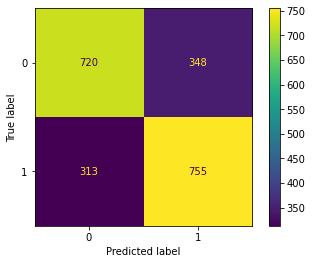

              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1068
           1       0.68      0.71      0.70      1068

    accuracy                           0.69      2136
   macro avg       0.69      0.69      0.69      2136
weighted avg       0.69      0.69      0.69      2136

ROC_AUC_score: 0.6905430711610487
Accuracy: 0.6905430711610487
Precision_score: 0.6844968268359021
Recall_score: 0.7069288389513109


In [38]:
base_model_history = model_training(base_model,x_train,y_train,x_test,y_test)

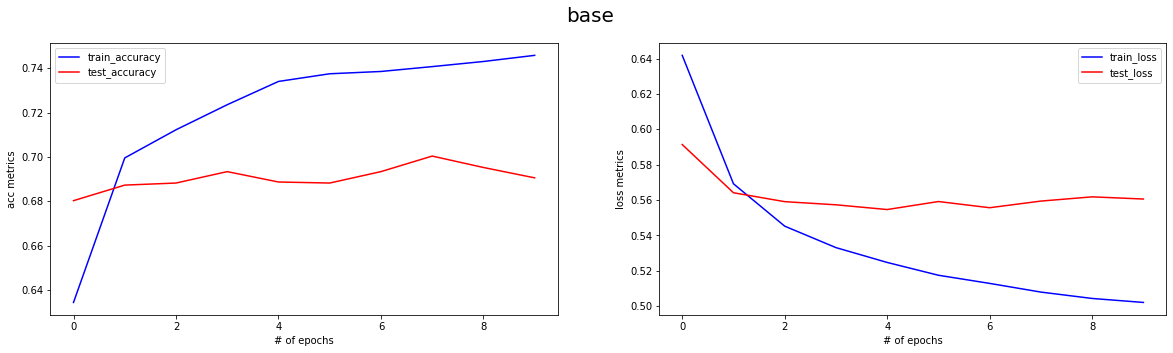

67/67 [==============================] - 0s 1ms/step - loss: 0.5606 - binary_accuracy: 0.6905


[0.5605510473251343, 0.6905430555343628]

In [39]:
plot(base_model,base_model_history,'base','binary_accuracy')

### Our model

#### Neurons reduced model

In [40]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(8, activation='relu', input_shape=(34,)))
reduced_model.add(layers.Dense(1, activation='sigmoid'))
reduced_model._name = 'Reduced_model'
reduced_model.summary()

Model: "Reduced_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 280       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


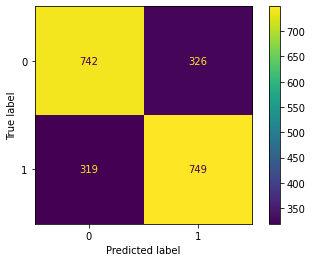

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      1068
           1       0.70      0.70      0.70      1068

    accuracy                           0.70      2136
   macro avg       0.70      0.70      0.70      2136
weighted avg       0.70      0.70      0.70      2136

ROC_AUC_score: 0.6980337078651686
Accuracy: 0.6980337078651685
Precision_score: 0.6967441860465117
Recall_score: 0.701310861423221


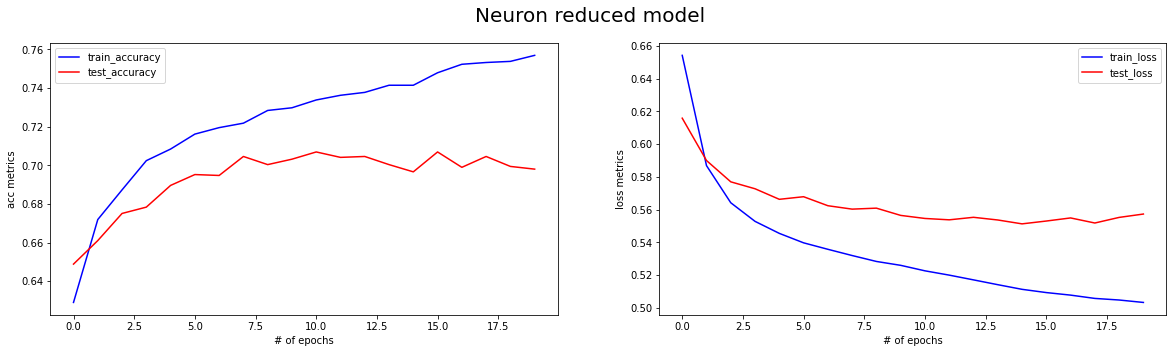

67/67 [==============================] - 0s 903us/step - loss: 0.5574 - binary_accuracy: 0.6980


[0.5573598742485046, 0.6980336904525757]

In [41]:
reduced_model_history = model_training(reduced_model,x_train,y_train,x_test,y_test)
plot(reduced_model,reduced_model_history,'Neuron reduced model','binary_accuracy')

#### Regularization model

In [42]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(11, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(34,)))
reg_model.add(layers.Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(1, activation='sigmoid'))
reg_model._name = 'L2_Regularization_model'
reg_model.summary()

Model: "L2_Regularization_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 11)                385       
                                                                 
 dense_6 (Dense)             (None, 4)                 48        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


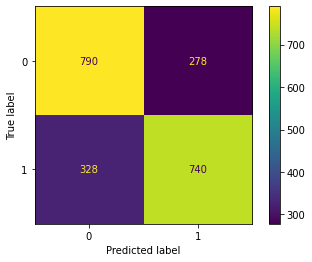

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1068
           1       0.73      0.69      0.71      1068

    accuracy                           0.72      2136
   macro avg       0.72      0.72      0.72      2136
weighted avg       0.72      0.72      0.72      2136

ROC_AUC_score: 0.7162921348314607
Accuracy: 0.7162921348314607
Precision_score: 0.7269155206286837
Recall_score: 0.6928838951310862


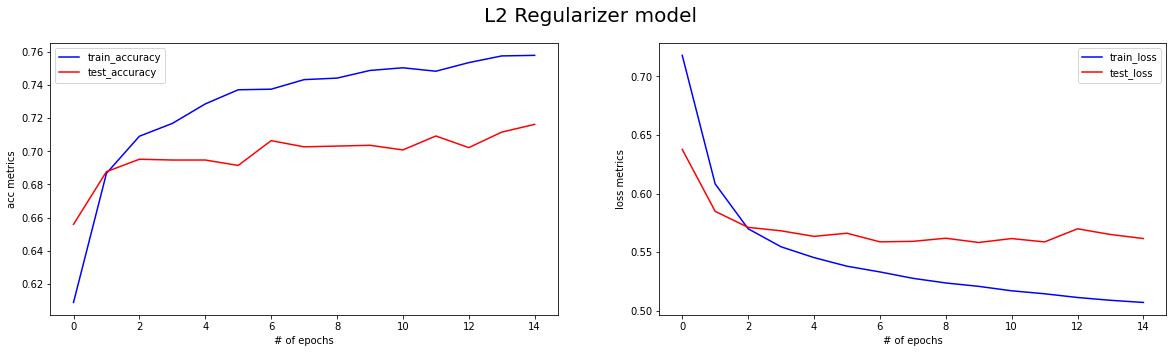

67/67 [==============================] - 0s 1ms/step - loss: 0.5615 - binary_accuracy: 0.7163


[0.5615339279174805, 0.716292142868042]

In [43]:
reg_model_history = model_training(reg_model,x_train,y_train,x_test,y_test)
plot(reg_model,reg_model_history,'L2 Regularizer model','binary_accuracy')

#### Dropout layer model

In [44]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(11, activation='relu', input_shape=(34,)))
drop_model.add(layers.Dropout(0.01))
drop_model.add(layers.Dense(4, activation='relu'))
drop_model.add(layers.Dropout(0.01))
drop_model.add(layers.Dense(1, activation='sigmoid'))
drop_model._name = 'Dropout_layers_model'
drop_model.summary()

Model: "Dropout_layers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 11)                385       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 48        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


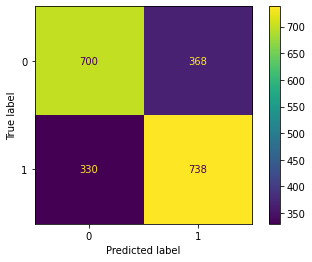

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1068
           1       0.67      0.69      0.68      1068

    accuracy                           0.67      2136
   macro avg       0.67      0.67      0.67      2136
weighted avg       0.67      0.67      0.67      2136

ROC_AUC_score: 0.6732209737827716
Accuracy: 0.6732209737827716
Precision_score: 0.6672694394213382
Recall_score: 0.6910112359550562


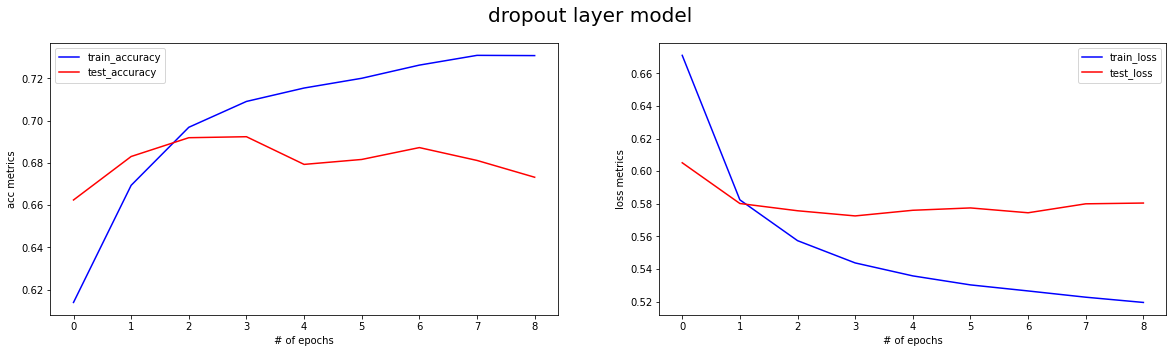

67/67 [==============================] - 0s 1ms/step - loss: 0.5805 - binary_accuracy: 0.6732


[0.58045893907547, 0.6732209920883179]

In [45]:
drop_model_history = model_training(drop_model,x_train,y_train,x_test,y_test)
plot(drop_model,drop_model_history,'dropout layer model','binary_accuracy')

#### Combined all model

In [46]:
combine_model = models.Sequential()
combine_model.add(layers.Dense(11,activation = 'relu', input_shape = (34,),kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.01))
combine_model.add(layers.Dense(8,activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
combine_model.add(layers.Dropout(0.01))
combine_model.add(layers.Dense(1,activation = 'sigmoid'))
combine_model._name = 'Combined_model'
combine_model.summary()

Model: "Combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 11)                385       
                                                                 
 dropout_2 (Dropout)         (None, 11)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 96        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 490
Trainable params: 490
Non-trainable params: 0
_________________________________________________________________


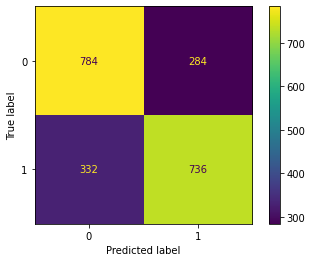

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1068
           1       0.72      0.69      0.70      1068

    accuracy                           0.71      2136
   macro avg       0.71      0.71      0.71      2136
weighted avg       0.71      0.71      0.71      2136

ROC_AUC_score: 0.7116104868913857
Accuracy: 0.7116104868913857
Precision_score: 0.7215686274509804
Recall_score: 0.6891385767790262


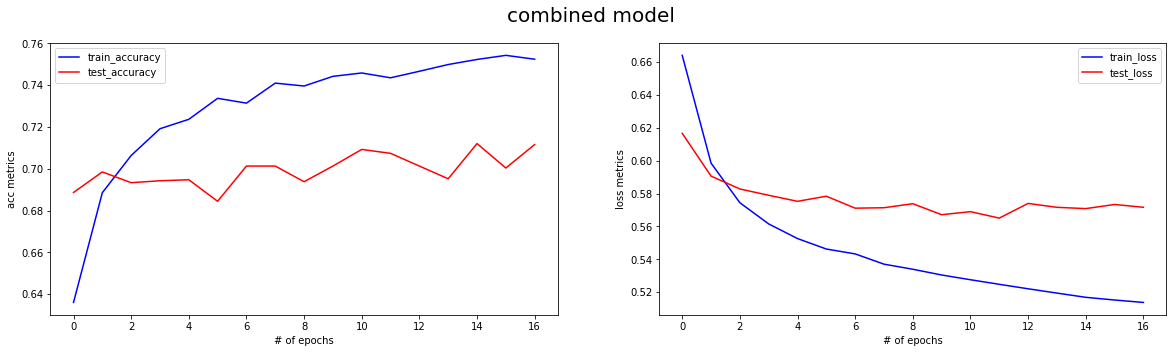

67/67 [==============================] - 0s 1ms/step - loss: 0.5717 - binary_accuracy: 0.7116


[0.5716982483863831, 0.7116104960441589]

In [47]:
combine_model_history = model_training(combine_model,x_train,y_train,x_test,y_test)
plot(combine_model,combine_model_history,'combined model','binary_accuracy')

### Keras tuner model

In [48]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=5,
    overwrite=True,
    directory="my_dir",
    project_name="imb 1, Epochs = 100",
    
)

In [49]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input nuerons (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 5, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': None}


In [50]:
tuner.search(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),callbacks =[tf.keras.callbacks.EarlyStopping(patience=5)] )

Trial 10 Complete [00h 00m 27s]
val_accuracy: 0.6994381904602051

Best val_accuracy So Far: 0.6994381904602051
Total elapsed time: 00h 04m 52s


In [51]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values.items()

dict_items([('input nuerons', 53), ('activation', 'relu'), ('num_layers', 1), ('units_0', 76), ('dropout', False), ('lr', 0.09211908831949574), ('units_1', 21)])

In [52]:
tuner_model = tuner.hypermodel.build(best_hps)
tuner_history = tuner_model.fit(x_train, y_train, epochs=epochs, validation_split=0.2,verbose=0,callbacks=callback)
tuner_model._name = 'Keras_tuner_model'
val_acc_per_epoch = tuner_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 15


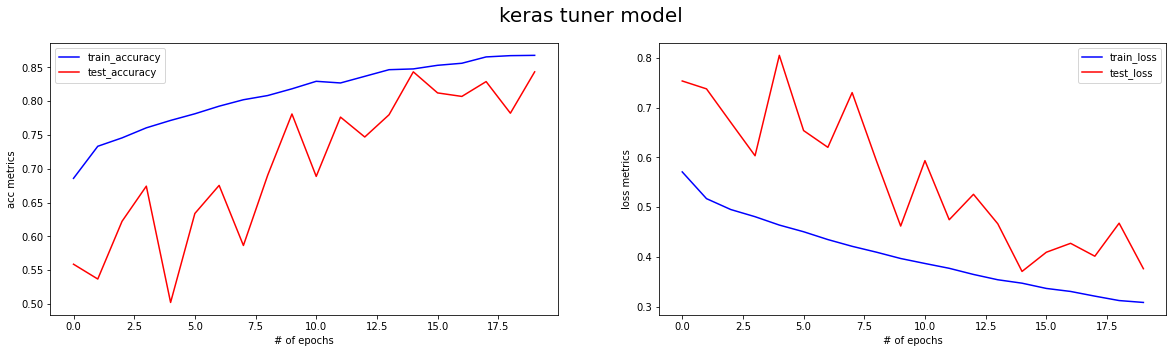

67/67 [==============================] - 0s 1ms/step - loss: 0.7790 - accuracy: 0.6620


[0.7789692878723145, 0.6619850397109985]

In [53]:
plot(tuner_model,tuner_history,'keras tuner model',metric = 'accuracy')

- Keras tuner model shows more loss and less accuracy

### Model with model comparison

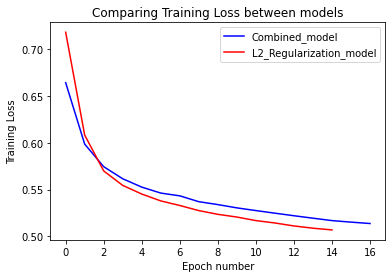

In [123]:
compare_models_by_metric(combine_model,reg_model,combine_model_history,reg_model_history,'loss')

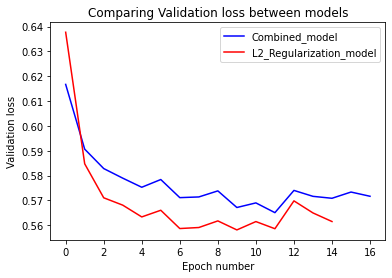

In [124]:
compare_models_by_metric(combine_model,reg_model,combine_model_history,reg_model_history,'val_loss')

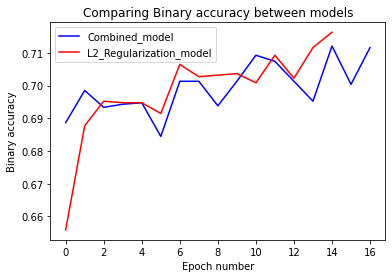

In [125]:
compare_models_by_metric(combine_model,reg_model,combine_model_history,reg_model_history,'val_binary_accuracy')

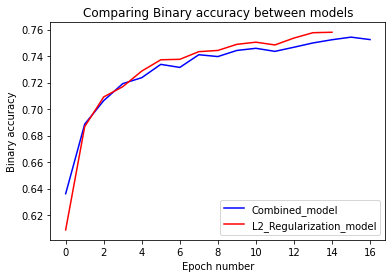

In [132]:
compare_models_by_metric(combine_model,reg_model,combine_model_history,reg_model_history,'binary_accuracy')

# Summary

- We have compared two model with maximum mean score of accuracy, precision and recall.
- Two best models are <b>Combined model</b> in which we have added L2 regularizer in kernel, dropout layers with characteristics of base model. Sole, <b>L2 regularizer model</b> with just L2 regularizer added in kernel initilizers.
- Epochs are less in range 10-20 because samples are less. Supported by EarlyStopping which helps to stop over training of models.
- <b>Validation loss</b>  - Both models showed best testing loss, but combined model's loss is continued to grow after regularizer model. Regularizer model showed continuous decline in the beggining but got stable after sometime.
- <b>Validation accuracy</b> - Learning curve was not smooth on validation accuracy which shows model had difficulty in testing with samples, some reasons may include newly added data which model has never seen, some samples with values which model has not excepted.
- <b>Trianing Loss</b> - Both have smooth learning curve which shows both are good on training loss but combined model's loss is lesser as compare to regularizer model.
- <b>Training Accuracy</b> - Regularized model showed more accuracy